In [60]:
import os
import os.path
import time
import json
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import brier_score_loss
#from sklearn.metrics import RocCurveDisplay
import datetime
from sklearn.utils import shuffle
from sklearn.preprocessing import MaxAbsScaler
from sklearn import metrics
from tqdm import trange

from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
from scipy.stats import pearsonr

#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers

from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Layer
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

#from models import Dense, Dropout, LSTM, Sequential
#from keras.layers import Dense
#from keras.layers import Dropout
#from keras.layers import LSTM
#from keras.models import Sequential

import time

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


import matplotlib.dates as mdates
import datetime as dt
import scipy

In [30]:
## FUNCTIONS
def loadJSONexpert(dname,fname,SEIZURETRACKER_START,TODAY_DATE):
    print('reading json...')
    os.chdir(dname) 
    d = pd.read_json(fname)
    S2 = pd.json_normalize(d.iloc[9],record_path ='Seizures')
    DT = S2['Date_Time']
    # note: if %z is in this format string then those dates with no UTC correction will turn into NaT
    justDates = pd.to_datetime(DT,errors='coerce',format='%Y-%m-%d %H:%M:%S',utc=True)
    #justDates[pd.isna(justDates)] = pd.to_datetime(DT,errors='coerce',format='%Y-%m-%d %H:%M:%S')   

    uid = S2['Patient_ID']
    uids = uid.astype('category')
    uidNums = uids.cat.codes

    #make a new dataframe that has only the stuff I actually care about. NO ERROR CHECKING YET.
    newdf = pd.DataFrame({'ID':uidNums,
        'dt':justDates,
        'dur':np.ones(len(uidNums)),
        'gtcTF':np.ones(len(uidNums)),
        'uid':uid})

    # gett rid of entries with invalid dates
    if (SEIZURETRACKER_START==''):
        newdf2 = newdf
    else:
        tStart=pd.to_datetime(SEIZURETRACKER_START,utc=True)
        tEnd=pd.to_datetime(TODAY_DATE,utc=True)
        newdf2=newdf[(tStart<=justDates) & (justDates<tEnd)]

    return newdf2

def buildModel_binary():
    # uses binary output
    # inputs:
    #  windowSize - how far back is the lookback
    # howManyFeatures - how many covariates used
    # modelKIND - if 0, use GRU, if 1 use LSTM, if 2 use BiLSTM. DEFAULT=1
    # outputs:
    #  model - the deep network model

    # constants
    windowSize = 84
    howManyFeatures = 1
    howManyNeurons1 = 64
    howManyNeurons2 = 32
    # if 0, use GRU, if 1 use LSTM, if 2 use BiLSTM
    modelKIND=1

    model = Sequential()

    model.add(LSTM(howManyNeurons1,
                    input_shape=(windowSize,howManyFeatures),
                    activation='relu',
                    stateful=False,return_sequences=True,
                    name='RNN1'))
    model.add(Dropout(0.5,name='D1'))
    model.add(LSTM(howManyNeurons1,name='RNN2'))


    model.add(Dropout(0.5,name='D2'))
    model.add(Dense(howManyNeurons2, activation='relu',name='MLP1'))
    model.add(Dense(howManyNeurons2, activation='relu',name='MLP2'))
    model.add(Dense(1,activation='sigmoid', name='MLP3'))
    #model.compile(loss='binary_crossentropy', optimizer='adam')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    #model.summary()
    # draw the model too
    #plot_model(model, show_shapes=True,rankdir='TB',to_file='model.pdf')
    return(model)


def makeLookBacks1(newdf3,START_DATE,END_DATE,lookBackFn,ptCSV,interDIR,daysBack,lookAhead,resampleRULE):
    # INPUT
    #  newdf3 - dataframe with preprocessed pt data
    #  START_DATE - first official date
    #  END_DATE - last official date
    #  lookBackFn - filename to output
    #  ptCSV - filename for CSV output
    #  interDIR - intermediate file directory
    #  daysBack - how many days back to look
    #  lookAhead - how many days ahead to look (NOT IMPLEMENTED)
    #  resampleRULE - how to resample the time data
    # OUTPUTS
    #   howmany - how many seizures

    # similar to makeLookBacks but for 1 patient, and will fill zeros for non-reported seizures
    #forecastDF = pd.DataFrame()
    resultD = pd.DataFrame()
    #traintest = pd.DataFrame()
    #ptNum = pd.DataFrame()
    #ptNumTrain = pd.DataFrame()
    #ptNumTest = pd.DataFrame()
    #splitPercent = 0.8
    #maxT = int(splitPercent*len(ptLIST)) ## THIS IS HOW MANY PATIENTS USED IN TRAINING
    #print('Begin make lookBacks loop')

    thisPt = newdf3.dropna(axis=0,how='any',subset=['dt'])
    thisPt2= thisPt.drop_duplicates(subset=['dt'],keep='first')
    thisPt2= thisPt2.sort_values(by='dt',ascending=True,na_position='last')
    thisPt2= thisPt2.reset_index(drop=True)
    numSzs = thisPt2.shape[0]
    # take a sec to calculate the total average SF (sz/day) for this diary
    oneDay=np.timedelta64(1,'D')
    #fullDiaryDur = (thisPt2.dt.iloc[-1] - thisPt2.dt.iloc[0] )  / oneDay
    #mSF = numSzs/fullDiaryDur

    ## this code no longer assumes multiple covariates
    ## also I added code to allow for zeros from beginning date to end date
    theOnesAndZeros = np.concatenate([np.zeros(1),np.ones(numSzs),np.zeros(1)])
    theINDS = pd.DataFrame({'dt':thisPt2.dt})
    i0 = pd.DataFrame({'dt':[pd.to_datetime(START_DATE,utc=True)]})
    i1 = pd.DataFrame({'dt':[pd.to_datetime(END_DATE,utc=True)]})
    theINDS = pd.concat([i0,theINDS,i1],ignore_index=True)

    ts=pd.Series(theOnesAndZeros,index=theINDS.dt)

    DF = ts.resample(resampleRULE).sum().fillna(0)
    X = np.array(DF)
    mySeries, numRows = calculateML1(X,daysBack,lookAhead)

    theseNums = pd.DataFrame(np.ones((mySeries[0].shape[0],1))*0)
    #ptNum = ptNum.append(theseNums,ignore_index=True)
    ptNum = pd.DataFrame(theseNums)
    #sTraintest = len(traintest)
    traintest = pd.DataFrame(mySeries)
    #traintest = traintest.append(mySeries,ignore_index=True)
    #resultTemp = pd.DataFrame({'a_i':0,'numSz':[numSzs],'durDiary':[fullDiaryDur],'SF':[mSF],'uid':[thisPt2.uid[0]]})
    #resultD = resultD.append(resultTemp)

    #print(numSzs,fullDiaryDur)

    #print('Writing output file...')
    os.chdir(os.path.expanduser('~'))
    os.chdir(interDIR)
    #resultD.to_csv(ptCSV,index=False)
    #print('Writing pickle file...')

    with open(lookBackFn + '.pkl','wb') as f:
        pickle.dump([traintest,ptNum], f)

    print('Done with lookbacks.')
    return

def calculateML1(X,window_size,lookAhead):
    # this only uses 1 covariate (unlike from deepFunctions)
    # generate the shifted 2D matrix that can become train and validate
    # INPUTS
    #  X - the counts vector for szs per day
    #  window_size - how big a lookback
    #  lookAhead - how big to look forward  (NOT IMPLEMENTED!!!)
    # OUTPUTS
    #  makes a list of dataframes [sz counts,durations,gtcTF,szType...]
    #  mytrain - training data (list of dataframes)
    #  mytest - testing data (list of dataframes)
    #  myfulltest - all the data, uncut, in case this is wanted (list of dataframes)

    # create lookback matrix for dailyCounts (for testing)
    series = pd.DataFrame(X)
    series_s = series.copy()

    # produce columns of shifted signal
    for i in range(window_size):
        tempS = series_s.shift(-(i+1))
        series = pd.concat([series, tempS], axis = 1)

    # some of the shifts will result in ROWs with NA. Drop those.
    series.dropna(axis=0, inplace=True)

    # shuffle an ordered set of indices, then use those on all covariates
    # the consequence here is that temporal order is lost - each "sample" is
    # shuffled among the other samples. For train and test purposes, that's ok
    # because the columns preserve the temporal lookback which is the only part
    # we are actually interested in
    series_temp = series.copy()
    s1 = series
    numRows = s1.shape[0]
    # this is from sklearn
    #inds = shuffle(range(numRows))
    #series = series_temp.iloc[inds,:]

    return(series,numRows)
    
def make_One_ready1(data,use_binary,look_ahead):
    # from deepFunctions, made for only 1 covariate
    # INPUT:
    #  data - training OR testing data
    #  use_binary - use only the nonzero state
    #  look_ahead - how many steps ahead to look (typically 1)
    # OUTPUTS:
    #  data_X - the input for training OR testing
    #  data_y - the output for training OR testing

    # OF NOTE (look_ahead currently not used)
    # if true, then max value from any covariate is 1
    doNormalizing = 1

    # initialize these 3D arrays...
    data_num_rows = data[0].shape[0]
    data_num_cols = data[0].shape[1]
    data_X = np.zeros((data_num_rows,data_num_cols-1,1))

    data_Xt = data.iloc[:,:-1]
    data_Xv = data_Xt.values
    if doNormalizing==1 and len(data_Xv)>0:
        # also some normalizing the training...
        # get max for each covariate separately
        # then normalize that covariate on that max of ROWs (MaxAbsScaler goes via COLS)
        data_Xvt = data_Xv.transpose()
        data_XvtN = MaxAbsScaler().fit_transform(data_Xvt)
        data_Xv = data_XvtN.transpose()
    
    data_X[:,:,0] = data_Xv
    
    # covariates not needed here
    data_y = data.iloc[:,-1]

    #binarize
    data_y = data_y.values > 0
    return(data_X,data_y)


def read_xlfile(dname,fname):
    os.chdir(dname) 
    X = pd.read_excel(fname)
    return X
    
def load_and_test_v2(modelF,dname,fname,thisPRE,interDIR):
    print('loading model...' + modelF)
    model = buildModel_binary()
    model.load_weights(modelF, by_name=False, skip_mismatch=False)
    #model = load_model(modelF)
    # load raw data
    newdf = loadJSONexpert(dname,fname,SEIZURETRACKER_START,TODAY_DATE)
    #newdf = loadCSVexport(dname,fname,SEIZURETRACKER_START,TODAY_DATE)
    # build covariates as a file
    ptLIST, uniqueINDs = np.unique(newdf.ID,return_index=True)
    ptUIDs = pd.DataFrame(newdf.iloc[uniqueINDs].uid)
    ptUIDs = ptUIDs.reset_index(drop=True)
    # build the lookup table for record ID numbers
    lookupX = read_xlfile(theDIR,STIDfile)
    recordID = np.zeros(len(ptUIDs))
    for K in range(len(ptUIDs)):
        thisUID = ptUIDs.iloc[K].values[0]
        temp = lookupX.loc[lookupX['ST relationship ID'] == thisUID]
        if temp.size>0:
            recordID[K] = temp['RedCap record number'].values[0]
            if np.isnan(recordID[K]):
                recordID[K] = 0
    ptUIDs['recordID'] = recordID.astype('int')
    complianceX = read_xlfile(theDIR,complianceFn)
    rLIST = np.array(complianceX['record number'])
    for K in range(len(ptLIST)):
        lookBackFn = theDIR + 'oneLookBack'
        ptCSV = theDIR + 'deletmecsv'
        #print('making lookbacks...')
        thisPt = newdf[newdf['uid']==ptUIDs.uid[K]]
        thisRECORD = ptUIDs.recordID[K]
        temp =  np.where(thisRECORD==rLIST)[0]
        
        if len(temp)>0:
            rowNum = temp[0]
            print(f'Patient {K}: {ptUIDs.uid[K]} thisRECORD = {thisRECORD} rowNum = {rowNum} shape={thisPt.shape}')
            signupdate = complianceX['signup date'].iloc[rowNum]
            enddate = complianceX['END'].iloc[rowNum]
            effectiveEnd = pd.to_datetime(complianceX['effective end'].iloc[rowNum])
            effectiveStart = pd.to_datetime(complianceX['effective startdata'].iloc[rowNum])
            if (effectiveEnd == pd.NaT) or (effectiveEnd=='NaT') or pd.isnull(effectiveEnd):
                realEND = enddate.strftime('%Y-%m-%d %H:%M%z')
            else:
                realEND = effectiveEnd.strftime('%Y-%m-%d %H:%M%z')
            if (effectiveStart == pd.NaT) or (effectiveStart=='NaT') or pd.isnull(effectiveStart):
                tempdate = signupdate - datetime.timedelta(84)     # If there is no change to startdate, then take 3 months before
                realSTART = tempdate.strftime('%Y-%m-%d %H:%M%z')
            else:
                realSTART = effectiveStart.strftime('%Y-%m-%d %H:%M%z')
            
            
            tempA = thisPt.dropna(axis=0,how='any',subset=['dt'])
            tempB= tempA.drop_duplicates(subset=['dt'],keep='first')
            tempC = tempB[tempB.dt <= realEND]
            tempD = tempC[tempC.dt >= realSTART]
            if tempD.size==0:
                print('Warning: NO SEIZURES AT ALL.')
            print(f'{K}=row{rowNum} :: {realSTART} - {realEND} ....{signupdate}        -- {enddate} -- START: {effectiveStart}  END: {effectiveEnd} ')
            makeLookBacks1(tempD,realSTART,realEND,lookBackFn + str(K),ptCSV,interDIR,daysBack,lookAhead,resampleRULE)
            #makeLookBacks1(thisPt,SEIZURETRACKER_START,TODAY_DATE,lookBackFn + str(K),ptCSV,interDIR,daysBack,lookAhead,resampleRULE)
            # load up the file
            os.chdir(interDIR)
            with open(lookBackFn + str(K) + '.pkl','rb') as f:
                test,numtest = pickle.load(f)
            # prepare the file
            #print('preparing the file...')
            [test_X,test_y] = make_One_ready1(test,use_binary,look_ahead)
            # test
            #print('Done. Now predicting...')
            
            ## THIS WAS A BUG. Used scaled matrix.
            ##RMR = np.mean(test_X[:,:,0],axis=1)
            RMR = np.mean(np.ceil(test_X[:,:,0]),axis=1)
            preds = model.predict(test_X,batch_size=batch_size,verbose=1)
            os.chdir(dname)
            print('Saving predictions...')
            #theMat = np.concatenate([test_y,np.reshape(preds,-1)])
            theMat = np.concatenate([np.reshape(test_y,(-1,1)),preds,np.reshape(RMR,(-1,1))],axis=1)
            #np.save(thisPRE + str(K) +  'predsFile',theMat)
            
            idtxt = ptUIDs.uid[K]
            np.savetxt(f'{thisPRE}{thisRECORD}.csv',theMat,fmt='%0.4f',header='y,pred,RMR',comments='',delimiter=',')
            #x = pd.read_csv(f'{thisPRE}{idtxt}.csv',delimiter=',')
        else:
            print(f'ERROR - no rec number. Patient {K}: {ptUIDs.uid[K]} thisRECORD = {thisRECORD} shape={thisPt.shape}')
        
        
    print('Done with the whole thing.')
    return

def drawFIG(x,figID):
    # INPUTS:
    #  x - dataframe with y, pred, and RMR
    #  figID - the unqiue patient ID number

    M1 = np.reshape(np.array(x.y),(1,-1))
    M2 = np.reshape(np.array(x.pred),(1,-1))
    M3 = np.reshape(np.array(x.RMR),(1,-1))

    fig, axs = plt.subplots(nrows=3, figsize=(18, 3.0))

    grid = plt.GridSpec(3, 5, wspace=0.4, hspace=0.3)
    plt.subplot(grid[0,:])
    im = plt.imshow(M1,cmap=plt.get_cmap('YlOrRd'))
    plt.title('A. True Seizures')
    plt.yticks([])   
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(7))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(AutoMinorLocator(7))

    #now=d2
    #then=d1
    #days = mdates.drange(now,then,dt.timedelta(days=1))

    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
    #plt.gcf().autofmt_xdate()

    plt.subplot(grid[1,:])
    plt.imshow(M2,cmap=plt.get_cmap('YlOrRd'))
    plt.title('B. Forecast Value')
    plt.yticks([])
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(7))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(AutoMinorLocator(7))
    
    plt.subplot(grid[2,:])
    im3=plt.imshow(M3,cmap=plt.get_cmap('YlOrRd'))
    plt.title('C. Random Forecast')
    plt.xlabel('Time (days)')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(7))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(AutoMinorLocator(7))
    
    plt.yticks([])

    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    #cax = plt.axes([0.85, 0.1, 0.02, 0.8])
    plt.colorbar(cm.ScalarMappable(norm=None, cmap=plt.get_cmap('YlOrRd')),cax=cax)
    print(figID)
    plt.show()
    fig.savefig(f'Fig{figID}',dpi=300)
    return

def drawFIG2(x,figID):
    # INPUTS:
    #  x - dataframe with y, pred, and RMR
    #  figID - the unqiue patient ID number

    M1 = np.reshape(np.array(x.y),(1,-1))
    M2 = np.reshape(np.array(x.pred),(1,-1))
    M3 = np.reshape(np.array(x.RMR),(1,-1))
    M12 = np.concatenate([M1,M2],axis=0)
    M13 = np.concatenate([M1,M3],axis=0)

    fig, axs = plt.subplots(nrows=2, figsize=(18, 3.0))

#    grid = plt.GridSpec(2, 5, wspace=0.4, hspace=0.3)
    plt.subplot(2,1,1)
    im = plt.imshow(M12,cmap=plt.get_cmap('YlOrRd'))
    
    plt.title('A. True Seizures over AI')
    plt.yticks([])   
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(7))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(AutoMinorLocator(7))

    plt.subplot(2,1,2)
    plt.imshow(M13,cmap=plt.get_cmap('YlOrRd'))
    plt.title('B. True Seizures over RMR')
    plt.yticks([])
    plt.xlabel('Time (days)')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(7))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(AutoMinorLocator(7))
        
    plt.yticks([])

#    fig.subplots_adjust(right=0.8)
#    cax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
    #cax = plt.axes([0.85, 0.1, 0.02, 0.8])
 #   plt.colorbar(cm.ScalarMappable(norm=None, cmap=plt.get_cmap('YlOrRd')),cax=cax)
    print(figID)
    plt.show()
    fig.savefig(f'Fig{figID}',dpi=300)
    return

def calcAUCtiw(pred,y,makePLOT=False):
    aucN = 40
    threshlist = np.linspace(0,1,aucN)
    thisSens = np.zeros(aucN)
    thisTIW = np.zeros(aucN)
    aucTIW= 0
    for threshi in range(aucN):
        threshPred = (pred>threshlist[threshi]) + 0.0
        
        TP = np.sum(np.logical_and(y==1,threshPred==1))
        FN = np.sum(np.logical_and(y==1,threshPred==0))
        thisSens[threshi] = TP / (TP + FN)
        thisTIW[threshi] = np.mean(threshPred)
    
    if makePLOT==True:
        plt.plot(thisTIW,thisSens,'x-')
        plt.show()
    aucTIW  = metrics.auc(thisTIW, thisSens)
    return aucTIW

def get_p_val_TIW(pred,y):
    reps = 1000
    inds = np.arange(len(pred))
    aucTIW =  calcAUCtiw(pred,y[inds])
    aucP = np.zeros(reps)
    for i in range(reps):
        inds2 = np.random.permutation(inds)
        newpred = np.array(pred[inds2].copy())
        aucP[i] =  calcAUCtiw(newpred,y)
    
    p = np.mean((aucTIW>aucP)+0.0)
    print(f'num={len(y)} howmany1y={np.sum(y)}')
    return aucTIW,p

In [25]:
x = np.random.random(10)
inds = np.arange(10)
inds2 = np.random.permutation(inds)
x2 = x[inds2]
print(x)
print(x2)

[0.66588325 0.01460161 0.76800163 0.11068691 0.72666094 0.20108054
 0.53040163 0.75321936 0.23314148 0.29054762]
[0.53040163 0.66588325 0.23314148 0.76800163 0.01460161 0.72666094
 0.20108054 0.29054762 0.11068691 0.75321936]


In [6]:
## CONSTANTS
thisBASE = '/Users/danielgoldenholz/Documents/GitHub/deepMan/'
modelFn = thisBASE + 'OUTPUT/OUTPUT_for_paper/holdout_mod1_cov1_win84fullMODEL.h5'
theDIR=thisBASE + 'PROSPECTIVE/'
interDIR = theDIR + 'TEMP/'
#fn='STFullExportBIDMC_20180312.csv_Seizures.txt'
#fn='STDataSharePID15b2a3590cv68z_20211214.csv'
#fn ='STDataSharePID15b2a3590cv68z_ST20220113CSV.csv'
#fn='STDataSharePID15b2a3590cv68z_ST20220113JSON.json'
#fn='STDataSharePID15b2a3590cv68z_ST20220210JSON.json'
#fn='STDataSharePID15b2a3590cv68z_ST20220310JSON.json'
#n='STDataSharePID15b2a3590cv68z_ST20220407JSON.json'
#fn='STDataSharePID15b2a3590cv68z_ST20220505JSON.json'
#fn='STDataSharePID15b2a3590cv68z_ST20220527JSON.json'
fn='STDataSharePID15b2a3590cv68z_ST20220614JSON.json'
complianceFn = 'de-ID-v4.xlsx'
STIDfile='STid.xlsx'
# note these dates should be year-month-day
# TODAY_DATE is last possible date. SEIZURETRACKER_START is 84+28 days before that.
#today = date.today()
#TODAY_DATE = today.strftime('%Y-%m-%d')
#TODAY_DATE= '2022-01-13 00:00-0500'
#TODAY_DATE = '2022-02-10 00:00-0500'
#TODAY_DATE = '2022-03-01 00:00-0500'
#TODAY_DATE = '2022-04-01 00:00-0500'
TODAY_DATE = '2022-05-27 00:00-0500'
study_START = '2021-11-10 00:00-0500'
d1 = pd.to_datetime(TODAY_DATE,utc=True)
#thisCHUNK = datetime.timedelta(84 + 28)
#thisCHUNK = datetime.timedelta(28)
#d2 = d1 - thisCHUNK
d2 = pd.to_datetime(study_START,utc=True)
SEIZURETRACKER_START = d2.strftime('%Y-%m-%d %H:%M%z')
#SEIZURETRACKER_START='2007-12-01'

#previously used this but very uneven split CUTOFF='2015-11-30'

lookAhead=1
look_ahead=1
minSz=0
resampleRULE='24H'
ts=pd.Series([1,1],index=pd.to_datetime(['2018-1-1','2018-1-2']))
DF = ts.resample(resampleRULE).sum().fillna(0)
howManyPerDay = len(DF)-1
window_size = howManyPerDay * (3 * 4 * 7)
daysBack= window_size
use_binary=1
batch_size = 5000


## MAIN#
#load_and_test(modelFn,theDIR,fn,'OnePt',d1)

In [5]:

load_and_test_v2(modelFn,theDIR,fn,'TwoPt',interDIR)


loading model.../Users/danielgoldenholz/Documents/GitHub/deepMan/OUTPUT/OUTPUT_for_paper/holdout_mod1_cov1_win84fullMODEL.h5
reading json...
Patient 0: BID15f1fcPID thisRECORD = 41 rowNum = 34 shape=(96, 5)
0=row34 :: 2021-09-22 00:00 - 2022-01-12 00:00 ....2021-12-15 00:00:00        -- 2022-05-04 00:00:00 -- START: NaT  END: 2022-01-12 00:00:00 
Done with lookbacks.


2022-10-20 09:51:38.157847: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 292ms/step
Saving predictions...
ERROR - no rec number. Patient 1: BID16f535PID thisRECORD = 44 shape=(8, 5)
Patient 2: BID25aa35PID thisRECORD = 33 rowNum = 27 shape=(741, 5)
2=row27 :: 2021-09-02 00:00 - 2022-02-03 00:00 ....2021-11-25 00:00:00        -- 2022-04-14 00:00:00 -- START: NaT  END: 2022-02-03 00:00:00 
Done with lookbacks.
1/1 [==============================] - 0s 25ms/step
Saving predictions...
Patient 3: BID293e04PID thisRECORD = 21 rowNum = 17 shape=(34, 5)
3=row17 :: 2021-08-20 00:00 - 2021-12-17 00:00 ....2021-11-12 00:00:00        -- 2022-04-01 00:00:00 -- START: NaT  END: 2021-12-17 00:00:00 
Done with lookbacks.
1/1 [==============================] - 0s 21ms/step
Saving predictions...
Patient 4: BID2e2651PID thisRECORD = 10 rowNum = 7 shape=(38, 5)
4=row7 :: 2021-08-19 00:00 - 2022-01-06 00:00 ....2021-11-11 00:00:00        -- 2022-03-31 00:00:00 -- START: NaT  END: 2022-01-06 00:00:00 
Done with lookbacks.
1/1 [==========

reading json...


100%|██████████| 1000/1000 [00:22<00:00, 44.48it/s]


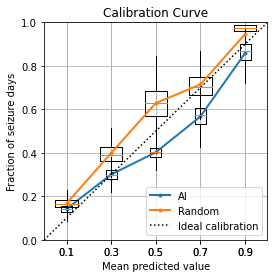

means - AUC = 0.8215622487673254 +/- 0.03890772051023643 bss = 0.1383994466799497 +/- 0.06298980523482925
means - AUCr = 0.7759383419940914 +/- 0.03666538623096897
medians  - AUC = 0.8229649318292817 -[0.7421883893219171, 0.8892389993945505] bss = 0.13326407585646738 +/- [0.029828919350989865, 0.26636752878418446]
medians  - AUCr = 0.7776667916202067 -[0.697683027298085, 0.8426265230915642]
mann whitney U = 1.3883206874681934e-120


In [63]:
# get the confidence intervals

def get_bin_inds(pred):
    # given some predictions, how many bins will come back for the calibration? which bin indices?
    # assume 5 bins
    indlist = []
    bins = [0,.2,.4,.6,.8,1]
    maxB = len(bins)-1
    for K in range(maxB):
        binL = bins[K]
        binH = bins[K+1]
        if np.sum(np.logical_and(pred>=binL,pred<=binH))>0:
            indlist.append(K)
    return indlist            
        

maxN = 46
BSSlist = np.zeros(maxN)
theLIST = np.ones((maxN,8))*(-1)
iterC = 0
newdf = loadJSONexpert(theDIR,fn,SEIZURETRACKER_START,TODAY_DATE)
# build covariates as a file
ptLIST, uniqueINDs = np.unique(newdf.ID,return_index=True)

rng = np.random.default_rng()
REPS = 1000

BSS = np.zeros(REPS)
auc = np.zeros(REPS)
aucR = np.zeros(REPS)
prob_true = -np.ones((REPS,5))
prob_trueR = -np.ones((REPS,5))

for thisREP in trange(REPS):
    newlist = rng.choice(np.arange(maxN),maxN,replace=True)
        
    firstOne = True
    countUP = 0
    for K in newlist:
        dontskip=False
        if os.path.exists(f'TwoPt{K}.csv'):
            temp=pd.read_csv(f'TwoPt{K}.csv')   
            #dontskip=True 
            if firstOne==True:
                p = temp.copy()
                firstOne=False
            else:
                p = pd.concat([p,temp],ignore_index=True)
            dontskip=True
            if np.sum(temp['y'])==0:
                #print(f'{K} had no seizures.')
                dontskip=False
            if np.sum(temp['y'])==temp.shape[0]:
                #print(f'{K} had every day of seizures.')
                dontskip=False
        if dontskip==True:
            if 0:
                theLIST[K,0] = K
                brierAI = brier_score_loss(y_true=temp['y'], y_prob=temp['pred'])
                brierRMR = brier_score_loss(y_true=temp['y'], y_prob=temp['RMR'])
                fpr, tpr, thresholds = metrics.roc_curve(temp['y'], temp['pred'], pos_label=1)
                auc = metrics.auc(fpr, tpr)
                BSS = 1 - (brierAI / brierRMR)
                if BSS<-1:
                    BSS = -1
                BSSlist[iterC] =BSS
                print(f'record {K} : BSS=  {BSS:0.2} brierAI={brierAI:0.2} brierRMR={brierRMR:0.2}')

                if BSS>0.8:
                    #drawFIG3(temp,ptLIST[K])
                    L = len(temp['y'])
                    plt.subplot(1,2,1)
                    plt.plot(temp.y[:-1],temp.pred[1:],'.')
                    plt.title('1 back')
                    plt.subplot(1,2,2)
                    plt.plot(temp.y[:-2],temp.pred[2:],'.')
                    plt.title('2 back')
                    
                    plt.show()
                iterC += 1 
                
                theLIST[countUP,:] = [K,np.round(BSS*100),temp.shape[0],np.sum(temp['y']),np.round(np.sum((temp['y'])/temp.shape[0])*100),np.round(brierAI*100), np.round(brierRMR*100), np.round(auc*100)/100]
                #Dtemp = pd.DataFrame(theLIST,columns=['Record','BSS','duration','szcount','fractionszdays','brierAI','brierRNR','aucAI'])
                #print(Dtemp.iloc[countUP])
                countUP += 1
    #break
            
    #theLIST = theLIST[:countUP,:]

    brierAI = brier_score_loss(y_true=p['y'], y_prob=p['pred'])
    brierRMR = brier_score_loss(y_true=p['y'], y_prob=p['RMR'])
    
    #print(f'Brier AI: {brierAI} RMR: {brierRMR}')
    BSS[thisREP] = 1 - (brierAI / brierRMR)
    fpr, tpr, thresholds = metrics.roc_curve(p['y'], p['pred'], pos_label=1)
    auc[thisREP] = metrics.auc(fpr, tpr)
    fpr, tpr, thresholds = metrics.roc_curve(p['y'], p['RMR'], pos_label=1)
    aucR[thisREP] = metrics.auc(fpr,tpr)
    #print(f'BSS = {BSS} AUC = {auc}')
    bin_inds = get_bin_inds(p['pred'])
    prob_true[thisREP,bin_inds], dummy = calibration_curve(p['y'], p['pred'], n_bins=5)
    bin_inds = get_bin_inds(p['RMR'])
    prob_trueR[thisREP,bin_inds], dummy = calibration_curve(p['y'], p['RMR'], n_bins=5)

#labels=['AI 0-.2','AI .2-.4','AI .4-.6','AI .6-.8','AI .8-1']
#labels=['Random 0-.2','Random .2-.4','Random .4-.6','Random .6-.8','Random .8-1']
plt.figure(figsize=(4,4))
plt.boxplot(prob_true,positions=[.1,.3,.5,.7,.9],showfliers=False,widths=0.05,showcaps=False)
meanK = np.zeros(5)
for K in range(5):
    meanK[K] = np.mean(prob_true[prob_true[:,K]>=0,K])
plt.plot([.1,.3,.5,.7,.9],meanK,'.-',label='AI',linewidth=2)
plt.boxplot(prob_trueR,positions=[.1,.3,.5,.7,.9],showfliers=False,widths=0.1,showcaps=False)
meanK = np.zeros(5)
for K in range(5):
    meanK[K] = np.mean(prob_trueR[prob_trueR[:,K]>=0,K])
plt.plot([.1,.3,.5,.7,.9],meanK,'.-',label='Random',linewidth=2)

plt.plot([0,1],[0,1],':k',label='Ideal calibration')
plt.grid(visible=True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of seizure days')
plt.title('Calibration Curve')
plt.legend()

plt.savefig('FigCalibration_curve-v2.tif',dpi=300)
plt.show()

print(f'means - AUC = {np.mean(auc)} +/- {np.std(auc)} bss = {np.mean(BSS)} +/- {np.std(BSS)}')
print(f'means - AUCr = {np.mean(aucR)} +/- {np.std(aucR)}')
print(f'medians  - AUC = {np.median(auc)} -{[np.percentile(auc,2.5),np.percentile(auc,97.5)]} bss = {np.median(BSS)} +/- {[np.percentile(BSS,2.5),np.percentile(BSS,97.5)]}')
print(f'medians  - AUCr = {np.median(aucR)} -{[np.percentile(aucR,2.5),np.percentile(aucR,97.5)]}')
s,p = scipy.stats.mannwhitneyu(auc,aucR)
print(f'mann whitney U = {p}')


In [62]:
print(f'mann whitney U = {p}')

mann whitney U = 1.9126261274486222e-135


In [42]:
prob_pred[0:10,:]

array([[0.06704814, 0.27852348, 0.50010634, 0.70067049, 0.90982313],
       [0.07090891, 0.28578222, 0.50364093, 0.69212486, 0.92431638],
       [0.06303277, 0.28137093, 0.49785019, 0.70732195, 0.94739258],
       [0.07391944, 0.28982606, 0.49611186, 0.69152212, 0.92635717],
       [0.06776134, 0.28934406, 0.50303854, 0.69601934, 0.94944475],
       [0.05459833, 0.28709459, 0.49492342, 0.67457238, 0.90167569],
       [0.06662082, 0.28681029, 0.49110436, 0.68777115, 0.93358402],
       [0.06494022, 0.30817712, 0.50306142, 0.69313808, 0.92730963],
       [0.06430843, 0.28222762, 0.49567778, 0.6924346 , 0.92370409],
       [0.07007313, 0.2699363 , 0.48763824, 0.6769094 , 0.9538018 ]])

In [8]:
# this was the old one (no longer correct)
print(f'AUC = {np.mean(auc)} -{[np.percentile(auc,2.5),np.percentile(auc,97.5)]} bss = {np.mean(BSS)} +/- {[np.percentile(BSS,2.5),np.percentile(BSS,97.5)]}')

AUC = 0.8202201876939725 -[0.7382911875480465, 0.884777406025892] bss = 0.33544250535150105 +/- [0.158085723334322, 0.497045001965459]


reading json...
num=141 howmany1y=60.0
record 2 : BSS=  0.089 brierAI=0.24 brierRMR=0.27 aucTIW = 0.58 pTIW = 0.997
num=141 howmany1y=35.0
record 4 : BSS=  -0.046 brierAI=0.21 brierRMR=0.2 aucTIW = 0.41 pTIW = 0.014
num=141 howmany1y=4.0
record 5 : BSS=  -0.095 brierAI=0.03 brierRMR=0.028 aucTIW = 0.34 pTIW = 0.055
num=113 howmany1y=39.0
record 6 : BSS=  0.03 brierAI=0.26 brierRMR=0.27 aucTIW = 0.5 pTIW = 0.426
num=141 howmany1y=140.0
record 7 : BSS=  0.92 brierAI=0.017 brierRMR=0.21 aucTIW = 0.5 pTIW = 0.0
num=141 howmany1y=7.0
record 8 : BSS=  -0.08 brierAI=0.052 brierRMR=0.048 aucTIW = 0.42 pTIW = 0.118
num=57 howmany1y=6.0
record 10 : BSS=  -0.035 brierAI=0.1 brierRMR=0.1 aucTIW = 0.51 pTIW = 0.544
num=141 howmany1y=19.0
record 11 : BSS=  -0.057 brierAI=0.13 brierRMR=0.12 aucTIW = 0.45 pTIW = 0.203
num=78 howmany1y=39.0
record 13 : BSS=  0.097 brierAI=0.32 brierRMR=0.35 aucTIW = 0.43 pTIW = 0.005
num=141 howmany1y=88.0
record 14 : BSS=  0.32 brierAI=0.23 brierRMR=0.33 aucTIW = 0.57

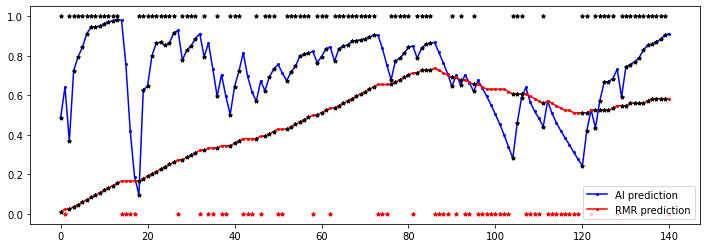

num=141 howmany1y=34.0
record 15 : BSS=  -0.047 brierAI=0.21 brierRMR=0.2 aucTIW = 0.42 pTIW = 0.037
num=141 howmany1y=38.0
record 17 : BSS=  -0.077 brierAI=0.21 brierRMR=0.2 aucTIW = 0.57 pTIW = 0.956
num=141 howmany1y=60.0
record 18 : BSS=  0.073 brierAI=0.27 brierRMR=0.29 aucTIW = 0.51 pTIW = 0.64
num=141 howmany1y=18.0
record 19 : BSS=  -0.097 brierAI=0.12 brierRMR=0.11 aucTIW = 0.54 pTIW = 0.708
num=36 howmany1y=6.0
record 21 : BSS=  0.086 brierAI=0.14 brierRMR=0.16 aucTIW = 0.7 pTIW = 0.966
num=141 howmany1y=27.0
record 22 : BSS=  -0.032 brierAI=0.17 brierRMR=0.17 aucTIW = 0.42 pTIW = 0.045
num=141 howmany1y=137.0
record 23 : BSS=  0.84 brierAI=0.032 brierRMR=0.2 aucTIW = 0.5 pTIW = 0.348
num=141 howmany1y=5.0
record 24 : BSS=  -0.11 brierAI=0.039 brierRMR=0.035 aucTIW = 0.47 pTIW = 0.268
num=141 howmany1y=7.0
record 25 : BSS=  -0.053 brierAI=0.05 brierRMR=0.048 aucTIW = 0.55 pTIW = 0.677
num=141 howmany1y=42.0
record 27 : BSS=  -0.081 brierAI=0.24 brierRMR=0.22 aucTIW = 0.48 pTI

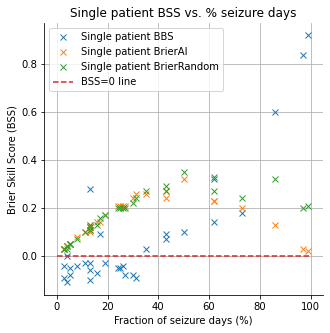

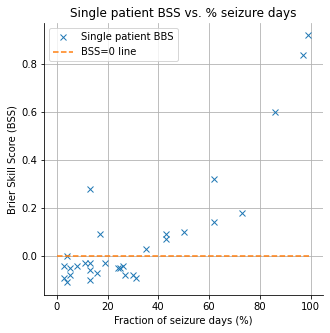

<Figure size 576x576 with 0 Axes>

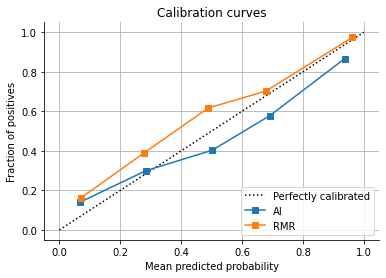

Days included: 3643.0
days min: 15.0 max: 141.0 median: 141.0
Seizures min: 1.0 max: 140.0 median: 27.0
    Record   BSS  duration  szcount  fractionszdays  brierAI  brierRNR  aucAI  \
17    24.0 -11.0     141.0      5.0             4.0      4.0       3.0   0.41   
13    19.0 -10.0     141.0     18.0            13.0     12.0      11.0   0.55   
2      5.0  -9.0     141.0      4.0             3.0      3.0       3.0   0.30   
28    41.0  -9.0      29.0      9.0            31.0     26.0      24.0   0.61   
19    27.0  -8.0     141.0     42.0            30.0     24.0      22.0   0.48   
5      8.0  -8.0     141.0      7.0             5.0      5.0       5.0   0.41   
11    17.0  -8.0     141.0     38.0            27.0     21.0      20.0   0.60   
21    29.0  -7.0     141.0     22.0            16.0     14.0      13.0   0.61   
7     11.0  -6.0     141.0     19.0            13.0     13.0      12.0   0.44   
1      4.0  -5.0     141.0     35.0            25.0     21.0      20.0   0.40   
18   

In [57]:
# make the report for the individuals...

from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt


def drawFIG3(x,figID):
    # INPUTS:
    #  x - dataframe with y, pred, and RMR
    #  figID - the unqiue patient ID number

    M1 = np.array(x.y)
    M2 = np.array(x.pred)
    M3 = np.array(x.RMR)
    
    t = np.arange(len(x.y))
    plt.figure(figsize=(12,4))
    colorf = [[0,0,0],[.4,.4,.4]]
    plt.plot(t,M2,'o-',color='b',markersize=2, label = 'AI prediction')
    plt.plot(t,M3,'o-',color='r',markersize=2, label = 'RMR prediction')
    plt.plot(t[M1==1],M2[M1==1],'*',color='k',markersize=4)
    plt.plot(t[M1==1],M3[M1==1],'*',color='k',markersize=4)
    plt.plot(t[M1==1],0*t[M1==1] + 1,'*',color='k',markersize=4)
    plt.plot(t[M1==0],0*t[M1==0] + 0,'*',color='r',markersize=4)
    
    
    plt.legend()
    plt.savefig(f'Fig{figID}',dpi=300)
    plt.show()    
    
    
maxN = 46
BSSlist = np.zeros(maxN)
theLIST = np.ones((maxN,11))*(-1)
iterC = 0
newdf = loadJSONexpert(theDIR,fn,SEIZURETRACKER_START,TODAY_DATE)
# build covariates as a file
ptLIST, uniqueINDs = np.unique(newdf.ID,return_index=True)

    
firstOne = True
countUP = 0
for K in range(maxN):
    dontskip=False
    if os.path.exists(f'TwoPt{K}.csv'):
        temp=pd.read_csv(f'TwoPt{K}.csv')   
        #dontskip=True 
        if firstOne==True:
            p = temp.copy()
            firstOne=False
        else:
            p = pd.concat([p,temp],ignore_index=True)
        dontskip=True
        if np.sum(temp['y'])==0:
            print(f'{K} had no seizures.')
            dontskip=False
        if np.sum(temp['y'])==temp.shape[0]:
            print(f'{K} had every day of seizures.')
            dontskip=False
    if dontskip==True:
        #theLIST[K,0] = K
        brierAI = brier_score_loss(y_true=temp['y'], y_prob=temp['pred'])
        brierRMR = brier_score_loss(y_true=temp['y'], y_prob=temp['RMR'])
        fpr, tpr, thresholds = metrics.roc_curve(temp['y'], temp['pred'], pos_label=1)
        auc = metrics.auc(fpr, tpr)
        fpr, tpr, thresholds = metrics.roc_curve(temp['y'], temp['RMR'], pos_label=1)
        aucRMR = metrics.auc(fpr, tpr)
        
        # calculate TIW auc.
        aucTIW,pTIW = get_p_val_TIW(temp['pred'],temp['y'])
        
       
     
        BSS = 1 - (brierAI / brierRMR)
        if BSS<-1:
            BSS = -1
        BSSlist[iterC] =BSS
        print(f'record {K} : BSS=  {BSS:0.2} brierAI={brierAI:0.2} brierRMR={brierRMR:0.2} aucTIW = {aucTIW:0.2} pTIW = {pTIW:0.4}')

        if K==14:
            drawFIG3(temp,ptLIST[K])
            L = len(temp['y'])
            #plt.subplot(1,2,1)
            #plt.plot(temp.y[:-1],temp.pred[1:],'.')
            #plt.title('1 back')
            #plt.subplot(1,2,2)
            #plt.plot(temp.y[:-2],temp.pred[2:],'.')
            #plt.title('2 back')
            
            plt.show()
        iterC += 1 
        
        theLIST[countUP,:] = [K,np.round(BSS*100),temp.shape[0],np.sum(temp['y']),np.round(np.sum((temp['y'])/temp.shape[0])*100),
                              np.round(brierAI*100), np.round(brierRMR*100), np.round(auc*100)/100, np.round(aucTIW*100)/100, pTIW, np.round(aucRMR*100)/100]
        #Dtemp = pd.DataFrame(theLIST,columns=['Record','BSS','duration','szcount','fractionszdays','brierAI','brierRNR','aucAI'])
        #print(Dtemp.iloc[countUP])
        countUP += 1
#break
        
theLIST = theLIST[:countUP,:]

brierAI = brier_score_loss(y_true=p['y'], y_prob=p['pred'])
brierRMR = brier_score_loss(y_true=p['y'], y_prob=p['RMR'])
print(f'Brier AI: {brierAI} RMR: {brierRMR}')
BSS = 1 - (brierAI / brierRMR)
fpr, tpr, thresholds = metrics.roc_curve(p['y'], p['pred'], pos_label=1)
auc = metrics.auc(fpr, tpr)
print(f'BSS = {BSS} AUC = {auc}')
print(f'Good = {np.sum(BSSlist>0)} total = {iterC}')
#print(np.sort(np.round(BSSlist*100)/100))
sublist = theLIST[theLIST[:,0]>(-1)]
if 0:
    plt.figure(figsize=(8,6))
    plt.plot(sublist[:,1],'x-',label='BSS')
    plt.plot(sublist[:,4],'o-',label='freq')
    plt.legend()
    plt.title('BSS and seizure rates')
    plt.show()

    plt.plot(sublist[:,7],sublist[:,4],'x')
    plt.title('AUC vs % of seizure days')
    plt.show()

#x_retro,y_retro = check_retrospective()
#r_retro,p_retro = pearsonr(x_retro,y_retro)
#print(f'RETRO   r = {r_retro:0.3} p={p_retro}')

r_pro,p_pro = pearsonr(sublist[:,4],sublist[:,1])
print(f'PRO   r = {r_pro:0.3} p={p_pro}')
#fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
plt.figure(figsize=(5,5))
#plt.plot(x_retro,0.01*y_retro,'.',alpha=0.4,label='Retrospective')
#plt.plot(sublist[:,4],.01*sublist[:,1],'x',label='Prosepctive')
plt.plot(sublist[:,4],.01*sublist[:,1],'x',label='Single patient BBS')
plt.plot(sublist[:,4],.01*sublist[:,5],'x',label='Single patient BrierAI')
plt.plot(sublist[:,4],.01*sublist[:,6],'x',label='Single patient BrierRandom')

plt.plot([0,100],[0,0],'--',label='BSS=0 line')
plt.title('Single patient BSS vs. % seizure days')
plt.ylabel('Brier Skill Score (BSS)')
plt.xlabel('Fraction of seizure days (%)')
plt.legend()
plt.grid(True)
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.savefig('Prospective_for_appendixD.tif',dpi=300)
plt.show()

plt.figure(figsize=(5,5))
#plt.plot(x_retro,0.01*y_retro,'.',alpha=0.4,label='Retrospective')
#plt.plot(sublist[:,4],.01*sublist[:,1],'x',label='Prosepctive')
plt.plot(sublist[:,4],.01*sublist[:,1],'x',label='Single patient BBS')

plt.plot([0,100],[0,0],'--',label='BSS=0 line')
plt.title('Single patient BSS vs. % seizure days')
plt.ylabel('Brier Skill Score (BSS)')
plt.xlabel('Fraction of seizure days (%)')
plt.legend()
plt.grid(True)
ax1 = plt.gca()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.savefig('Prospective_fig2.tif',dpi=300)
plt.show()


#ax2 = plt.subplot(1,2,2)
plt.figure(figsize=(8,8))
disp = CalibrationDisplay.from_predictions(y_true=p['y'], y_prob=p['pred'],name='AI')
ax2 = plt.gca()
disp2 = CalibrationDisplay.from_predictions(ax=ax2,y_true=p['y'], y_prob=p['RMR'],name='RMR')
ax2.set_title('Calibration curves')
ax2.grid(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['bottom'].set_visible(False)
#ax2.spines['left'].set_visible(False)
plt.savefig('Prospective_fig1.tif',dpi=300)
plt.show()
if 0:
    plt.plot(sublist[:,4],sublist[:,5],'x',label='Brier score AI')
    plt.plot(sublist[:,4],sublist[:,6],'x',label='Brier score RMR')
    plt.plot(sublist[:,4],sublist[:,1],'x',label='BSS')
    plt.plot([0,100],[0,0],'--',label='BSS=0 line')
    plt.xlabel('Days with seizures (%)')
    plt.ylabel('BSS and Brier Score')
    plt.legend()
    plt.title('Brier score /BSS vs % of days with seizures')

    plt.show()
mylist = theLIST[theLIST[:,0]>-1]
D = pd.DataFrame(mylist,columns=['Record','BSS','duration','szcount','fractionszdays','brierAI','brierRNR','aucAI','aucAItiw','pTIW','aucRMR'])
print(f'Days included: {np.sum(mylist[:,2])}')
print(f'days min: {np.min(mylist[:,2])} max: {np.max(mylist[:,2])} median: {np.median(mylist[:,2])}')
print(f'Seizures min: {np.min(mylist[:,3])} max: {np.max(mylist[:,3])} median: {np.median(mylist[:,3])}')
D2 = D.sort_values(by=['BSS'])
print(f'{D2}')
D2 = D.sort_values(by=['aucAI'])
print(f'{D2}')
print(f'N={D.shape}')
print(f'AUC {np.mean(D.aucAI):0.2} +/- {np.std(D.aucAI):0.2}')
print(f'AUCrmr {np.mean(D.aucRMR):0.2} +/- {np.std(D.aucRMR):0.2}')
print(f'AUC tiw {np.mean(D.aucAItiw):0.2} +/- {np.std(D.aucAItiw):0.2}')
print(f'BSS {np.median(D.BSS/100)} +/- {np.percentile(D.BSS/100,25)}-{np.percentile(D.BSS/100,75)}')
print(f'number of individual TIW values with p<0.05: {np.sum( pTIW<0.05)}')

In [11]:
def check_retrospective():
    #fnretro = '/Users/danielgoldenholz/Documents/GitHub/deepMan/OUTPUT/OUTPUT_for_paper/holdoutisThisReal_v2.csv'
    fnretro = '/Users/danielgoldenholz/Documents/GitHub/deepMan/isThisReal_CORRECTED_v1.csv'
    
    p = pd.read_csv(fnretro,names=['ID','y','pred','RMR'])
    ptLIST, uniqueINDs = np.unique(p.ID,return_index=True)
    maxN = len(ptLIST)
    theLIST = np.ones((maxN,8))*(-1)
    iterC=0
    BSSlist = np.zeros(maxN)
    for K in range(maxN):
        thisPt = ptLIST[K]
        temp = p[p['ID']==thisPt]
            
        dontskip=(temp.shape[0] > 0)
        if np.sum(temp.y)==temp.shape[0]:
            dontskip=False
            
        if dontskip==True:
            
            brierAI = brier_score_loss(y_true=temp['y'], y_prob=temp['pred'])
            brierRMR = brier_score_loss(y_true=temp['y'], y_prob=temp['RMR'])
            fpr, tpr, thresholds = metrics.roc_curve(temp['y'], temp['pred'], pos_label=1)
            auc = metrics.auc(fpr, tpr)
            BSS = 1 - (brierAI / brierRMR)
            if BSS<-1:
                BSS = -1
            BSSlist[iterC] =BSS
            if BSS<(-4):
                print(f'BSS=  {BSS} brierAI={brierAI} brierRMR={brierRMR}')
            iterC += 1 
            
            theLIST[K,:] = [ptLIST[K],np.round(BSS*100),temp.shape[0],np.sum(temp['y']),np.round(np.mean(temp['y'])*100),np.round(brierAI*100), np.round(brierRMR*100), np.round(auc*100)]
            #theLIST[K,:] = [ptLIST[K],np.round(BSS*100),temp.shape[0],np.sum(temp['y']),np.round(np.sum((temp['y'])/temp.shape[0])*100),np.round(brierAI*100), np.round(brierRMR*100), np.round(auc*100)]
            #Dtemp = pd.DataFrame(theLIST,columns=['Record','BSS','duration','szcount','fractionszdays','brierAI','brierRNR','aucAI'])
            #print(Dtemp.iloc[K])
            #drawFIG2(temp,ptLIST[K])


    brierAI = brier_score_loss(y_true=p['y'], y_prob=p['pred'])
    brierRMR = brier_score_loss(y_true=p['y'], y_prob=p['RMR'])
    print(f'Brier AI: {brierAI} RMR: {brierRMR}')
    BSS = 1 - (brierAI / brierRMR)
    print(f'BSS = {BSS}')
    print(f'Good = {np.sum(BSSlist>0)} total = {iterC}')
    #print(np.sort(np.round(BSSlist*100)/100))
    sublist = theLIST[theLIST[:,0]>(-1)]
    if 0:
        plt.figure(figsize=(8,6))
        plt.plot(sublist[:,1],'x-',label='BSS')
        plt.plot(sublist[:,4],'o-',label='freq')
        plt.legend()
        plt.title('BSS and seizure rates')
        plt.show()
        plt.plot(sublist[:,7]*100,sublist[:,4],'x')
        plt.title('AUC vs % of seizure days')
        plt.show()

    # this is the useful one
    if 0:
        plt.plot(sublist[:,4],sublist[:,1],'x')
        plt.plot([0,100],[0,0],'--')
        plt.title('BSS vs percentage of days with seizures')
        plt.show()
        
    if 0:
        plt.plot(sublist[:,4],sublist[:,5],'x',label='Brier score AI')
        plt.plot(sublist[:,4],sublist[:,6],'x',label='Brier score RMR')
        plt.plot(sublist[:,4],sublist[:,1],'x',label='BSS')
        plt.plot([0,100],[0,0],'--',label='BSS=0 line')
        plt.xlabel('Days with seizures (%)')
        plt.ylabel('BSS and Brier Score')
        plt.legend()
        plt.title('Brier score /BSS vs % of days with seizures')

        plt.show()

    mylist = theLIST[theLIST[:,0]>-1]
    D = pd.DataFrame(mylist,columns=['Record','BSS','duration','szcount','fractionszdays','brierAI','brierRNR','aucAI'])
    print(f'Days included: {np.sum(mylist[:,2])}')
    print(f'days min: {np.min(mylist[:,2])} max: {np.max(mylist[:,2])} median: {np.median(mylist[:,2])}')
    print(f'Seizures min: {np.min(mylist[:,3])} max: {np.max(mylist[:,3])} median: {np.median(mylist[:,3])}')
    D2 = D.sort_values(by=['BSS'])
    print(f'{D2}')
    D2 = D.sort_values(by=['aucAI'])
    print(f'{D2}')

    return sublist[:,4],sublist[:,1]


In [10]:
import pandas as pd
import numpy as np
os.chdir(theDIR)
x = pd.read_excel('filtered_initial.xlsx')
#x.sex = x.sex.astype('category')
C = x.groupby('sex').count()
print('males=1, females=2')
print(C.iloc[:,0])
print('handed r=1, l=2, mixed=3, i dontknow=4')
C = x.groupby('handed').count()
print(C.iloc[:,0])
print('epilepsytype 1=gen 2=focal 3=focal+gen 4=PNES 5=dontknow')
C = x.groupby('epilepsy_type').count()
print(C.iloc[:,0])
print('frontal')
C = x.groupby('focal_where___1').count()
print(C.iloc[:,0])
print('temporal')
C = x.groupby('focal_where___2').count()
print(C.iloc[:,0])
print('parietal')
C = x.groupby('focal_where___3').count()
print(C.iloc[:,0])
print('occipital')
C = x.groupby('focal_where___4').count()
print(C.iloc[:,0])
print('multifocal')
C = x.groupby('focal_where___5').count()
print(C.iloc[:,0])
print('dontknow')
C = x.groupby('focal_where___6').count()
print(C.iloc[:,0])
C = x['focal_where___1'] + x['focal_where___2']+ x['focal_where___3'] + x['focal_where___4'] + x['focal_where___5']
print('specified location at all')
print(np.sum(C))
print('CAUSE')
print('structural')
C = x.groupby('cause___1').count()
print(C.iloc[:,0])
print('genetic')
C = x.groupby('cause___2').count()
print(C.iloc[:,0])
print('infectious')
C = x.groupby('cause___3').count()
print(C.iloc[:,0])
print('metabolic')
C = x.groupby('cause___4').count()
print(C.iloc[:,0])
print('immune')
C = x.groupby('cause___5').count()
print(C.iloc[:,0])
print('dontknow')
C = x.groupby('cause___6').count()
print(C.iloc[:,0])
C = x['cause___1'] + x['cause___2']+ x['cause___3'] + x['cause___4'] + x['cause___5']
print('specified location at all')
print(np.sum(C))
print('surgery')
C = x.groupby('surgery').count()
print(C.iloc[:,0])



males=1, females=2
sex
1    17
2    14
Name: initialsurvey, dtype: int64
handed r=1, l=2, mixed=3, i dontknow=4
handed
1    23
2     6
3     2
Name: initialsurvey, dtype: int64
epilepsytype 1=gen 2=focal 3=focal+gen 4=PNES 5=dontknow
epilepsy_type
1     8
2    11
3     8
5     4
Name: initialsurvey, dtype: int64
frontal
focal_where___1
0    30
1     1
Name: initialsurvey, dtype: int64
temporal
focal_where___2
0    25
1     6
Name: initialsurvey, dtype: int64
parietal
focal_where___3
0    31
Name: initialsurvey, dtype: int64
occipital
focal_where___4
0    30
1     1
Name: initialsurvey, dtype: int64
multifocal
focal_where___5
0    29
1     2
Name: initialsurvey, dtype: int64
dontknow
focal_where___6
0    30
1     1
Name: initialsurvey, dtype: int64
specified location at all
10
CAUSE
structural
cause___1
0    22
1     9
Name: initialsurvey, dtype: int64
genetic
cause___2
0    25
1     6
Name: initialsurvey, dtype: int64
infectious
cause___3
0    30
1     1
Name: initialsurvey, dtype: int